<a href="https://colab.research.google.com/github/AzureAmber/STAT-390-Covid-Project/blob/ericazhang/Models/erica/6_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# These two lines avoid dead kernel after importing keras
#import os
#os.environ['KMP_DUPLICATE_LIB_OK']='True'

import keras

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import numpy as np
import seaborn as sns
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import warnings
from keras.layers import LSTM, Dense, Input
from keras.models import Sequential
from keras import Model
from keras.optimizers import Adam
from pandas.plotting import autocorrelation_plot
import time as time
warnings.filterwarnings("ignore")

In [7]:
train = pd.read_csv('train_nn.csv', parse_dates = ['date'])
train = train.drop(['continent', 'G20', 'G24'], axis = 1)
test = pd.read_csv('test_nn.csv', parse_dates = ['date'])
test = test.drop(['continent', 'G20', 'G24'], axis = 1)

print(train.shape)
print(test.shape)

(24771, 34)
(5900, 34)


In [8]:
# encode non-numeric features

days = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}
train['day_of_week'] = train['day_of_week'].map(days)
test['day_of_week'] = test['day_of_week'].map(days)

indicator_columns = ['total_tests_b', 'new_tests_b', 'positive_rate_b', 'total_vaccinations_b', 'extreme_poverty_b', 'stringency_index_b']

# Convert indicator variables to numeric: True to 1 and False to 0
for col in indicator_columns:
    train[col] = train[col].astype(int)
    test[col] = test[col].astype(int)

train.head()

,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,...,life_expectancy,population,month,day_of_week,total_tests_b,new_tests_b,positive_rate_b,total_vaccinations_b,extreme_poverty_b,stringency_index_b
0,Argentina,2020-01-20,5349898.0,0,127500.0,0,80946.854,0.0,1785.094,0.0,...,76.67,45510324,1,1,1,1,1,0,1,1
1,Argentina,2020-01-21,5349898.0,0,127500.0,0,80946.854,0.0,1785.094,0.0,...,76.67,45510324,1,2,1,1,1,0,1,1
2,Argentina,2020-01-22,5349898.0,0,127500.0,0,80946.854,0.0,1785.094,0.0,...,76.67,45510324,1,3,1,1,1,0,1,1
3,Argentina,2020-01-23,5349898.0,0,127500.0,0,80946.854,0.0,1785.094,0.0,...,76.67,45510324,1,4,1,1,1,0,1,1
4,Argentina,2020-01-24,5349898.0,0,127500.0,0,80946.854,0.0,1785.094,0.0,...,76.67,45510324,1,5,0,0,0,0,1,1


In [9]:
# add one-wk lag for new_cases

def add_lagged_features(df, target, lag_periods):
    lagged_df = df[[target]].shift(lag_periods)
    lagged_df.columns = [f'lag{lag_periods}_' + target]
    existing_lagged_col = f'lag{lag_periods}_' + target
    if existing_lagged_col in df.columns:
        df = df.drop(columns=[existing_lagged_col])
    df_with_lags = df.join(lagged_df)
    return df_with_lags.fillna(0)

train_with_lags = add_lagged_features(train, 'new_cases', 7)
test_with_lags = add_lagged_features(test, 'new_cases', 7)

In [ ]:
# normalize on country-level

def normalize(df, group_col, target, indicators, non_numeric):

    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    cols_to_normalize = numeric_cols.difference(indicators + [target] + non_numeric)

    df_normalized = df.copy()
    for col in cols_to_normalize:
        # Apply normalization within each region for the column
        df_normalized[col] = df.groupby(group_col)[col].transform(lambda x: (x - x.mean()) / x.std())

    df_normalized = df_normalized.fillna(0)
    return df_normalized

# List of indicator columns and non-numeric columns
indicators = ['total_tests_b', 'new_tests_b', 'positive_rate_b',
              'total_vaccinations_b', 'extreme_poverty_b', 'stringency_index_b']
non_numeric = ['date', 'location', 'day_of_week']

# Apply the normalize function to your train and test sets
train_normalized = normalize(train_with_lags, 'location', 'new_cases', indicators, non_numeric)
test_normalized = normalize(test_with_lags, 'location', 'new_cases', indicators, non_numeric)



train_encoded = pd.get_dummies(train_normalized, columns=['location'])
test_encoded = pd.get_dummies(test_normalized, columns=['location'])

In [ ]:
data=pd.concat([train_encoded, test_encoded])

data.set_index('date', inplace = True)

data.head(10)

,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,reproduction_rate,total_tests,...,location_Pakistan,location_Philippines,location_Russia,location_Saudi Arabia,location_South Africa,location_South Korea,location_Sri Lanka,location_Turkey,location_United Kingdom,location_United States
date,,,,,,,,,,,,,,,,,,,,,
2020-01-20,0.137968,0,0.877612,-0.756225,-0.306724,-0.531605,-0.038844,-0.756236,0.155424,-1.089388,...,0,0,0,0,0,0,0,0,0,0
2020-01-21,0.137968,0,0.877612,-0.756225,-0.306724,-0.531605,-0.038844,-0.756236,0.155424,-1.089388,...,0,0,0,0,0,0,0,0,0,0
2020-01-22,0.137968,0,0.877612,-0.756225,-0.306724,-0.531605,-0.038844,-0.756236,0.155424,-1.089387,...,0,0,0,0,0,0,0,0,0,0
2020-01-23,0.137968,0,0.877612,-0.756225,-0.306724,-0.531605,-0.038844,-0.756236,0.155424,-1.089387,...,0,0,0,0,0,0,0,0,0,0
2020-01-24,0.137968,0,0.877612,-0.756225,-0.306724,-0.531605,-0.038844,-0.756236,0.155424,1.642005,...,0,0,0,0,0,0,0,0,0,0
2020-01-25,0.137968,0,0.877612,-0.756225,-0.306724,-0.531605,-0.038844,-0.756236,0.155424,1.642005,...,0,0,0,0,0,0,0,0,0,0
2020-01-26,0.137968,0,0.877612,-0.756225,-0.306724,-0.531605,-0.038844,-0.756236,0.155424,-1.089387,...,0,0,0,0,0,0,0,0,0,0
2020-01-27,0.137968,0,0.877612,-0.756225,-0.306724,-0.531605,-0.038844,-0.756236,0.155424,-1.089386,...,0,0,0,0,0,0,0,0,0,0
2020-01-28,0.137968,0,0.877612,-0.756225,-0.306724,-0.531605,-0.038844,-0.756236,0.155424,-1.089386,...,0,0,0,0,0,0,0,0,0,0


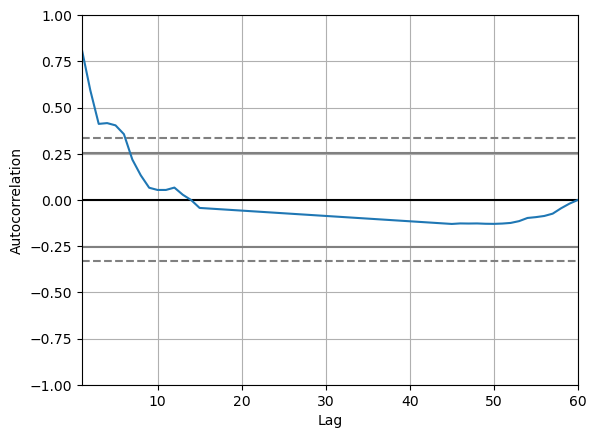

In [ ]:
# Plot autocorrelation for a more reasonable number of lags
autocorrelation_plot(train['new_cases'].iloc[:60])
plt.show()

# 7 looks like a reasonable lag to capture weekly seasonality

In [ ]:
def make_series(data):
    series=[]
    for i in range(7, len(data)+1):
        subdf=data[(i-7):i]
        series.append((data.index[i-1], data['new_cases'].values[i-1], subdf.drop(['new_cases'], axis=1).values))
    return series

series=make_series(data)
print(series[0][0], series[0][1].shape, series[0][2].shape)
train = series[:(data.loc[data.index < '2023-01-01'].shape[0]-6)]
test = series[(data.loc[data.index < '2023-01-01'].shape[0]-6):]

2020-01-26 00:00:00 () (7, 55)


# Training

In [ ]:
learning_rate = 0.01
batch_size = 32 # how many data points do I go through
epochs = 100 # how many times I run through my whole dataset
sequence_length = 7 # use the past 7 days to predict today

In [ ]:
inputs = Input(shape=(7,55))
lstm_out = LSTM(32)(inputs)
outputs = Dense(1)(lstm_out)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 7, 55)]           0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                11264     
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 11,297
Trainable params: 11,297
Non-trainable params: 0
_________________________________________________________________


In [ ]:
x=np.array([x[2].reshape(7,55)for x in train])
y=np.array([x[1] for x in train])

print(x.shape)
print(y.shape)

history = model.fit(
    x=x,y=y,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
)

(24765, 7, 55)
(24765,)
Epoch 1/100
774/774 [==============================] - 1s 2ms/step - loss: 2278974720.0000
Epoch 2/100
774/774 [==============================] - 1s 2ms/step - loss: 2271869184.0000
Epoch 3/100
774/774 [==============================] - 1s 2ms/step - loss: 2264842240.0000
Epoch 4/100
774/774 [==============================] - 1s 2ms/step - loss: 2257909504.0000
Epoch 5/100
774/774 [==============================] - 1s 2ms/step - loss: 2251029248.0000
Epoch 6/100
774/774 [==============================] - 1s 2ms/step - loss: 2244157184.0000
Epoch 7/100
774/774 [==============================] - 1s 2ms/step - loss: 2237327360.0000
Epoch 8/100
774/774 [==============================] - 1s 2ms/step - loss: 2230611200.0000
Epoch 9/100
774/774 [==============================] - 1s 2ms/step - loss: 2223979264.0000
Epoch 10/100
774/774 [==============================] - 1s 2ms/step - loss: 2217401856.0000
Epoch 11/100
774/774 [==============================] - 1s 2ms/st

774/774 [==============================] - 1s 2ms/step - loss: 1808602624.0000
Epoch 90/100
774/774 [==============================] - 1s 2ms/step - loss: 1804467456.0000
Epoch 91/100
774/774 [==============================] - 1s 2ms/step - loss: 1800365696.0000
Epoch 92/100
774/774 [==============================] - 1s 2ms/step - loss: 1796295552.0000
Epoch 93/100
774/774 [==============================] - 1s 2ms/step - loss: 1792407936.0000
Epoch 94/100
774/774 [==============================] - 1s 2ms/step - loss: 1788294912.0000
Epoch 95/100
774/774 [==============================] - 2s 3ms/step - loss: 1784234880.0000
Epoch 96/100
774/774 [==============================] - 2s 2ms/step - loss: 1780274944.0000
Epoch 97/100
774/774 [==============================] - 1s 2ms/step - loss: 1776260224.0000
Epoch 98/100
774/774 [==============================] - 2s 2ms/step - loss: 1772381824.0000
Epoch 99/100
774/774 [==============================] - 2s 3ms/step - loss: 1768494720.0000
E

In [ ]:
train_pred = pd.DataFrame(model.predict(x), columns=['yhat'], index=[x[0] for x in train])
test_pred = pd.DataFrame(model.predict(np.array([x[2].reshape(7,55) for x in test])), columns=['yhat'], index=[x[0] for x in test])
test_pred

185/185 [==============================] - 0s 951us/step


,yhat
2023-01-01,21510.931641
2023-01-02,12962.356445
2023-01-03,11572.679688
2023-01-04,11255.643555
2023-01-05,8677.064453
...,...
2023-09-09,23069.605469
2023-09-10,23063.927734
2023-09-11,23065.087891
2023-09-12,23068.580078


In [ ]:
# plotting the training data
y_train_real = train.loc[train_encoded.location_key_x == 'US_AK', 'new_confirmed']
y_train_real.index = train.loc[train.location_key_x == 'US_AK', 'date']
pd.concat([y_train_real, AK_train_pred['yhat']], axis=1).plot(figsize=(20,10))
plt.legend(['train', 'train_pred'])